In [ ]:
! pip install pyDOE 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=a1d645eecf04e5df9b49ba5c25dee0f7aa38be9c094578c5d2678e569e1bb754
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [ ]:
from scipy import integrate
import scipy.special as special
import torch
import torch.autograd as autograd         # Se usa para computar las derivadas
from torch import Tensor                  # Me permite definir tensores
import torch.nn as nn                     # Todo el paquete relacioando con NN
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #The LHS design is a statistical method for generating a quasi-random sampling distribution
import scipy.io
from sympy import *

#Set default dtype to float32
torch.set_default_dtype(torch.float)  #Defino el tipo de variable a utilizar

#PyTorch random number generator
torch.manual_seed(1234)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [ ]:
#Solucion cuando las opiniones iniciales son constantes.
def initial_constant(x,t,N_u):
  X = []
  #Me devuelve la solucion a un T fijo
  if len(t) == N_u:
    lower = t[0] - 1
    uper = 1 - t[0]
    pos = np.where((x<lower) | (x>uper),0,x) * 1/(2-2*t[0])
    X.append(pos)
  else:
    #Me devuelve la solucion para un rango temporal [0,T]
    for i in range(len(t)):
      lower = t[i][0] - 1
      uper = 1 - t[i][0]
      pos = np.where((x[i]<lower) | (x[i]>uper),0,x[0]) * 1/(2-2*t[0][0])
      X.append(pos)
  X = np.array(X)
  return X

In [ ]:
#epochs
steps=30000
lr=1e-1

#Arquitectura de la red
layers = np.array([2,50,50,50,50,50,50,1]) 

layers_1 = np.array([2,50,50,50,50,1])

N_u = 500 #Cantidad de puntos temporales
N_f = 5000 #Cantidad de puntos espaciales para cada T 

In [ ]:
class FCN_1(nn.Module):
    ##Neural Network
    def __init__(self,layers_1):

        super().__init__() #call __init__ from parent class 

        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')

        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_1[i], layers_1[i+1]) for i in range(len(layers_1)-1)]) 
        self.iter = 0

        'Xavier Normal Initialization'      
        for i in range(len(layers_1)-1):
                      
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         

            x = torch.from_numpy(x)                

        a = x.float()
        for i in range(len(layers_1)-2):  

            z = self.linears[i](a)              
            a = self.activation(z)    

        a = self.linears[-1](a)

        return a
  
    #Loss PDE
    def lossPDE(self,x_PDE,sol):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]
      loss_PDE=self.loss_function(f_x,sol)
      return loss_PDE
      
    def loss_1(self,x_PDE,sol):
      loss_pde=self.lossPDE(x_PDE,sol)
      return loss_pde

In [ ]:
class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() 
              
        'Funcion de activacion'
        self.activation = nn.Tanh()

        'Funcion de perdida a minimizar'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Inicio la red'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
    
        'Xavier Normal Initialization'
        'Initialization is the process of setting the initial values of weights for our models'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a      
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def Inte(self,g,X_train_Nf):      
      
      model1 = FCN_1(layers_1)

      model1.to(device)

      params = list(model1.parameters())

      optimizer = torch.optim.Adam(model1.parameters(),lr=lr,amsgrad=False)
      

      u = self.forward(g)            

      for i in range(steps):
        yh = model1(X_train_Nf)
        loss_1 = model1.loss_1(X_train_Nf,u)# use mean squared error
        optimizer.zero_grad()
        loss_1.backward()
        optimizer.step()
        if i%(steps/10)==0:
          print(loss_1)

      yh = model1(X_train_Nf).detach().numpy()
      
      return yh
    
    def loss_PDE(self, X_train_Nf):
                        
        g = X_train_Nf.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]                                                                                          
        
        u_t = u_x_t[:,[1]]
                                                
        F = (u*(2*(self.Inte(g,X_train_Nf)) - 1))
        
        F_x = autograd.grad(F,g,torch.ones([X_train_Nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

        F_x = F_x[:,[0]]

        f = u_t - F_x

        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,X_train_Nf,X_train_Nu,U_train_Nu):

        loss_u = self.loss_BC(X_train_Nu,U_train_Nu)
        loss_f = self.loss_PDE(X_train_Nf)
        
        loss_val = loss_f + loss_u
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_train_Nf,X_train_Nu,U_train_Nu)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(loss)

        return loss        
    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X_test)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
                
        return error_vec, u_pred

In [ ]:
t = np.linspace(0,100,N_f) #Simulo un espacio temporal entre 0 y 100s
x = np.linspace(-1,1,N_u) ##Simulo un espacio espacial entre -1 y 1

X,T = np.meshgrid(x,t)

In [ ]:
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_test[0]  # [-1. 0.]
ub = X_test[-1] # [1.  0.99]

#Solucion real
u_true = np.hstack((initial_constant(X,T,N_u).flatten()[:,None],T.flatten()[:,None]))


X_train = X[0]
U_train_Nu = initial_constant(X[0],T[0],N_u).reshape((N_u, 1))

idx = np.random.choice(X_train.shape[0],N_u,replace=False) 
X_train_Nu = np.hstack((X_train[idx].flatten()[:,None], T[0].flatten()[:,None]))

X_train_Nf = lb + (ub-lb)*lhs(2,N_f) 
X_train_Nf = np.vstack((X_train_Nf, X_train_Nu))

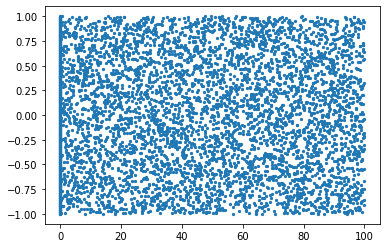

In [ ]:
plt.scatter(X_train_Nf[:,1],X_train_Nf[:,0],s=5)

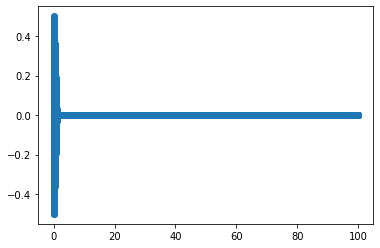

In [ ]:
plt.scatter(T,initial_constant(X,T,N_u))

In [ ]:
print("Puntos de colocacion:",X_train_Nf.shape)
print("Puntos de colocaion a t = 0:",X_train_Nu.shape)
print("Solucion a t = 0:",U_train_Nu.shape)
print("Puntos de evaluacion:",X_test.shape)
print("Solucion en mis puntos de evaluacion:",u_true.shape)

Puntos de colocacion: (5500, 2)
Puntos de colocaion a t = 0: (500, 2)
Solucion a t = 0: (500, 1)
Puntos de evaluacion: (2500000, 2)
Solucion en mis puntos de evaluacion: (2500000, 2)


In [ ]:
'Convert to tensor and send to GPU'
#Puntos de colocacion (Ver scatter de arriba)
X_train_Nf = torch.from_numpy(X_train_Nf).float().to(device)
#Puntos a t = 0
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
#Solucion a t = 0
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
#Puntos con los que voy a evaluar mi red
X_test = torch.from_numpy(X_test).float().to(device)
# Solucion real de mi ecuacion diferencial en los puntos X_test
u = torch.from_numpy(u_true).float().to(device)
#Tensor de ceros que uso en la funcion de perdida
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

PINN = FCN(layers)
       
PINN.to(device)

'Neural Network Summary'
print(PINN)

params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)
tensor(0.0159, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5500, 1])) that is different to the input size (torch.Size([5500, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
sol = np.hstack((u_pred.flatten()[:,None], T.flatten()[:,None]))

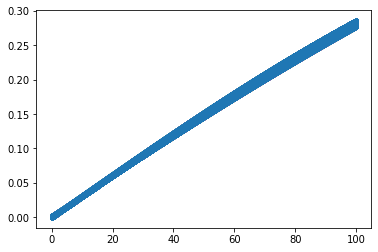

In [ ]:
Rango = 20000000
plt.scatter(sol[:,1][:Rango],sol[:,0][:Rango],s=5)
#plt.scatter(u_true[:,1][:Rango],u_true[:,0][:Rango],s=5)

In [ ]:
test_tensor = torch.randn((4, 2))

test_tensor1 = torch.tensor([[2,3,4],[0,0,0]])

int_tensor = torch.trapz(test_tensor,test_tensor1
print(test_tensor)
print(test_tensor1)
print(int_tensor)

tensor([[ 0.6483,  0.2725],
        [ 1.8637, -0.1177],
        [ 1.0928, -0.9760],
        [ 0.4906, -0.2545]])
tensor([[2, 3, 4],
        [0, 0, 0]])
